In [3]:
import time
import pyotp
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from kiteconnect import KiteConnect
from tabulate import tabulate
import sys
sys.path.append('c:/Users/Teresa Pious/Downloads/KiteConnect')
from kite_utils import display_dashboard

from config import api_key, api_secret, user_id, password, totp_secret

# Step 1: Get the login URL
kite = KiteConnect(api_key=api_key)
login_url = kite.login_url()

# Step 2: Setup Selenium
driver_path = "C:/Users/Teresa Pious/Downloads/Python Code for Scanning/chromedriver.exe"  # Update this
driver = webdriver.Chrome(service=Service(driver_path))
driver.get(login_url)

# Step 3: Enter Zerodha ID and password
time.sleep(5)
driver.find_element(By.ID, "userid").send_keys(user_id)
driver.find_element(By.ID, "password").send_keys(password)
driver.find_element(By.XPATH, "//button[@type='submit']").click()

# Step 4: Generate TOTP and submit
time.sleep(5)
totp = pyotp.TOTP(totp_secret).now()
driver.find_element(By.ID, "userid").send_keys(totp)
driver.find_element(By.XPATH, "//button[@type='submit']").click()

# Step 5: Wait for redirect and extract request_token from URL
time.sleep(5)
current_url = driver.current_url
driver.quit()

# Extract request_token from redirected URL
from urllib.parse import urlparse, parse_qs

parsed_url = urlparse(current_url)
request_token = parse_qs(parsed_url.query).get("request_token")[0]
print(f"Request Token: {request_token}")

# Step 6: Generate access token
data = kite.generate_session(request_token, api_secret=api_secret)
kite.set_access_token(data["access_token"])
print("Access Token:", data["access_token"])


Request Token: 2fubh1Rjf2DM0Bt9qeTBGD42QzjIbb8V
Access Token: 3X2x4APhTpZQADMTEyN75R9BWynZUlEa


In [ ]:
# Step 5: Fetch holdings
holdings = kite.holdings()


# Prepare data for tabulate
holdings_table_data = []
for h in holdings:
    # Calculate total quantity including MTF
    regular_qty = h['quantity'] + h['t1_quantity']
    mtf_qty = 0
    
    # Extract MTF quantity if exists
    if isinstance(h.get('mtf'), dict):
        mtf_qty = h['mtf'].get('quantity', 0)
    
    total_qty = regular_qty + mtf_qty
    
    if total_qty != 0:
        # Calculate investment including MTF
        regular_investment = regular_qty * h['average_price']
        mtf_investment = 0
        
        if isinstance(h.get('mtf'), dict):
            mtf_investment = h['mtf'].get('value', 0)
        
        total_investment = regular_investment + mtf_investment
        
        # Calculate P&L percentage based on total investment
        h['pnl%'] = (h['pnl']) / total_investment * 100 if total_investment > 0 else 0
        h['Investment'] = total_investment
        h['total_qty'] = total_qty
        h['mtf_qty'] = mtf_qty
        h['regular_qty'] = regular_qty
        
        holdings_table_data.append([
            h['tradingsymbol'],
            h['exchange'],
            h['regular_qty'],
            h['mtf_qty'],
            h['total_qty'],
            round(h['average_price'], 1),
            round(h['last_price'], 1),
            round(h['Investment'], 0),
            round(h['pnl'], 0),
            round(h['pnl%'], 2),
            round(h['day_change'], 2),
            round(h['day_change_percentage'], 2)
        ])

# Headers for the table
headers_holding = [
    "Symbol", "Exchange", "Regular Qty", "MTF Qty", "Total Qty", 
    "Avg Price", "Last Price", "Investment", "P&L", 'P&L%', 
    "Day Change", "% Change"
]

# Print Holdings Table
print("\n" + "="*50)
print("HOLDINGS (Including MTF)")
print("="*50)
print(tabulate(holdings_table_data, headers=headers_holding, tablefmt="fancy_grid"))

# Fetch all GTT orders
gtt_orders = kite.get_gtts()

# Prepare data for tabulation
gtt_table_data = []
for order in gtt_orders:
    if order['status'] == 'active':
        gtt_table_data.append([
            order['id'],
            order['condition']['exchange'],
            order['condition']['tradingsymbol'],
            order['condition']['trigger_values'][0],
            order['condition']['trigger_values'][1] if len(order['condition']['trigger_values']) > 1 else 0,
            order['orders'][0]['transaction_type'],
            order['orders'][0]['quantity'],
            order['orders'][0]['price'],
            order['status']
        ])

# Define headers
headers_gtt = ["ID", "Exchange", "Symbol", "SL Trigger Price", "TGT Trigger Price", 
               "Type", "Qty", "SL-Price", "Status"]

# Print GTT Orders Table
print("\n" + "="*50)
print("ACTIVE GTT ORDERS")
print("="*50)
print(tabulate(gtt_table_data, headers=headers_gtt, tablefmt="fancy_grid"))

# Prepare data for comparison
holdings_symbols = []  # List to store symbols from holdings
holdings_dict = {}  # Dictionary to store full holdings data

for h in holdings:
    regular_qty = h['quantity'] + h['t1_quantity']
    mtf_qty = 0
    
    if isinstance(h.get('mtf'), dict):
        mtf_qty = h['mtf'].get('quantity', 0)
    
    total_qty = regular_qty + mtf_qty
    
    if total_qty != 0:
        holdings_symbols.append(h['tradingsymbol'])
        holdings_dict[h['tradingsymbol']] = h

gtt_symbols = []  # List to store symbols from GTT orders
gtt_dict = {}  # Dictionary to store full GTT data

for order in gtt_orders:
    if order['status'] == 'active':
        gtt_symbols.append(order['condition']['tradingsymbol'])
        gtt_dict[order['condition']['tradingsymbol']] = order

# Find common stocks between holdings and GTT orders
common_stocks = []
for symbol in holdings_symbols:
    if symbol in gtt_symbols:
        common_stocks.append(symbol)

# Remove duplicates if any and sort alphabetically
common_stocks = sorted(list(set(common_stocks)))

# Print the results
print("\n" + "="*50)
print("COMPARISON RESULTS:")
print("="*50)
print(f"Total Holdings: {len(holdings_symbols)}")
print(f"Total Active GTT Orders: {len(gtt_symbols)}")
print(f"Common Stocks: {len(common_stocks)}")

# Optional: Create a detailed comparison table for common stocks
if common_stocks:
    print("\nDETAILED COMPARISON FOR COMMON STOCKS:")
    detailed_comparison = []
    
    for stock in common_stocks:
        # Find holdings data for this stock
        holdings_data = None
        for row in holdings_table_data:
            if row[0] == stock:  # Symbol is at index 0
                holdings_data = row
                break
        
        # Find GTT data for this stock
        gtt_data = None
        for row in gtt_table_data:
            if row[2] == stock:  # Symbol is at index 2 in GTT table
                gtt_data = row
                break
        
        if holdings_data and gtt_data:
            # Extract data (adjusted indices for new column structure)
            symbol = holdings_data[0]
            regular_qty = holdings_data[2]
            mtf_qty = holdings_data[3]
            total_qty = holdings_data[4]
            avg_price = holdings_data[5]
            last_price = holdings_data[6]
            investment = holdings_data[7]
            pnl = holdings_data[8]
            pnl_pct = holdings_data[9]
            sl_trigger = gtt_data[3]
            tgt_trigger = gtt_data[4]
            
            # Calculate additional metrics
            sl_percentage = round((avg_price - sl_trigger) / avg_price * 100, 2) if avg_price != 0 else 0
            capital_risk = round((avg_price - sl_trigger) * total_qty, 2) if total_qty != 0 else 0
            tgt_percentage = round((tgt_trigger - last_price) / last_price * 100, 2) if last_price != 0 else 0
            rr_ratio = round((last_price - avg_price) / (avg_price - sl_trigger), 2) if (avg_price - sl_trigger) != 0 else 0
            open_pnl_risk = round((last_price - sl_trigger) * total_qty, 2) if total_qty != 0 else 0
            
            # Append to detailed comparison
            detailed_comparison.append([
                symbol,           # Symbol
                regular_qty,      # Regular Qty
                mtf_qty,          # MTF Qty
                total_qty,        # Total Qty
                avg_price,        # Avg Price
                last_price,       # Last Price
                investment,       # Investment
                sl_trigger,       # SL Trigger Price
                tgt_trigger,      # TGT Trigger Price
                pnl,              # P&L
                pnl_pct,          # P&L%
                sl_percentage,    # SL%
                tgt_percentage,   # % to TGT
                rr_ratio,         # Current RR Ratio
                open_pnl_risk,    # Open PNL Risk
                capital_risk      # Capital Risk
            ])

    # Code to calculate and print total open risk
    Total_open_risk = 0
    for row in detailed_comparison:
        Total_open_risk += row[14]  # Open PNL Risk index
    print(f"Open PNL Risk: {Total_open_risk:.0f}")

    # Code to calculate and print total capital risk
    Total_risk = 0
    for row in detailed_comparison:
        Total_risk += row[15]  # Capital Risk index
    print(f"Capital Risk: {Total_risk:.0f}")
    
    # Code to calculate and print total open profit
    Total_profit = 0
    for row in detailed_comparison:
        Total_profit += row[9]  # P&L index
    print(f"Open profit: {Total_profit:.0f}")
    
    # Calculate summary statistics
    Total_investment = 0
    Total_regular_qty = 0
    Total_mtf_qty = 0
    for row in detailed_comparison:
        Total_investment += row[6]
        Total_regular_qty += row[1]
        Total_mtf_qty += row[2]
    
    print(f"Total Investment: {Total_investment:.0f}")
    print(f"Total Regular Qty: {Total_regular_qty:.0f}")
    print(f"Total MTF Qty: {Total_mtf_qty:.0f}")

    comparison_headers = [
        "Symbol", "Regular Qty", "MTF Qty", "Total Qty", "Avg Price", "Last Price",
        "Investment", "SL Trigger", "TGT Trigger", "P&L", "P&L%", 
        "SL%", "% to TGT", "RR Ratio", "Open PNL Risk", "Capital Risk"
    ]
    
    print("\n" + tabulate(detailed_comparison, headers=comparison_headers, tablefmt="fancy_grid"))

# Print holdings without GTT orders
holdings_without_gtt = []
for symbol in holdings_symbols:
    if symbol not in gtt_symbols:
        holdings_without_gtt.append(symbol)

if holdings_without_gtt:
    print("\n" + "="*50)
    print(f"HOLDINGS WITHOUT GTT ORDERS ({len(holdings_without_gtt)} stocks)")
    print("="*50)
    
    no_gtt_data = []
    for symbol in holdings_without_gtt:
        for row in holdings_table_data:
            if row[0] == symbol:
                no_gtt_data.append(row)
                break
    
    if no_gtt_data:
        print(tabulate(no_gtt_data, headers=headers_holding, tablefmt="fancy_grid"))
else:
    print("\n✓ All holdings have GTT orders configured!")

# PNL for holdings without GTT
pnl_without_gtt = 0
for symbol in holdings_without_gtt:
    for row in holdings_table_data:
        if row[0] == symbol:
            pnl_without_gtt += row[8]  # P&L index
            break
print(f"\nTotal P&L for holdings without GTT orders: {pnl_without_gtt:.0f}")


print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)

# add a ggt order modification funtion with limit price and trigger prices
def modify_gtt_order(kite, gtt_id, new_sl_price, new_tgt_price, ):
    try:
        response = kite.modify_gtt(
            gtt_id,
            trigger_values=[new_sl_price, new_tgt_price]
        )
        print(f"GTT Order {gtt_id} modified successfully.")
        return response
    except Exception as e:
        print(f"Error modifying GTT Order {gtt_id}: {e}")
        return None

Fetching holdings...
Fetching GTT orders...

HOLDINGS SUMMARY
╒════════════╤════════════╤═══════════════╤═══════════╤═════════════╤═════════════╤══════════════╤══════════════╤════════╤════════╤══════════════╤════════════╕
│ Symbol     │ Exchange   │   Regular Qty │   MTF Qty │   Total Qty │   Avg Price │   Last Price │   Investment │    P&L │   P&L% │   Day Change │   % Change │
╞════════════╪════════════╪═══════════════╪═══════════╪═════════════╪═════════════╪══════════════╪══════════════╪════════╪════════╪══════════════╪════════════╡
│ ADANIPORTS │ NSE        │            19 │         0 │          19 │      1513.8 │       1523.3 │        28762 │    180 │   0.63 │         6.4  │       0.42 │
├────────────┼────────────┼───────────────┼───────────┼─────────────┼─────────────┼──────────────┼──────────────┼────────┼────────┼──────────────┼────────────┤
│ AUBANK     │ BSE        │            34 │         0 │          34 │       881.9 │        950.2 │        29983 │   2326 │   7.76 │       

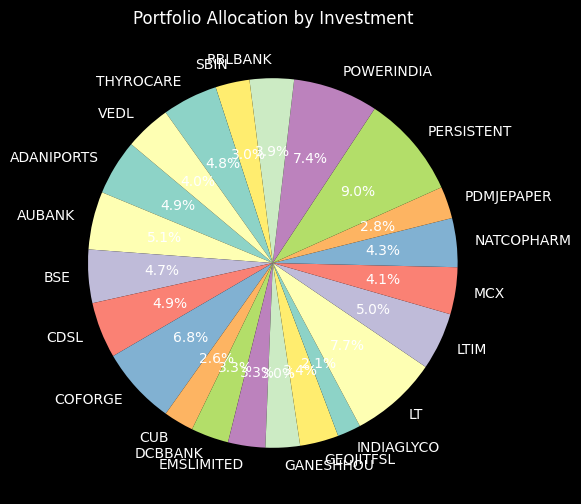

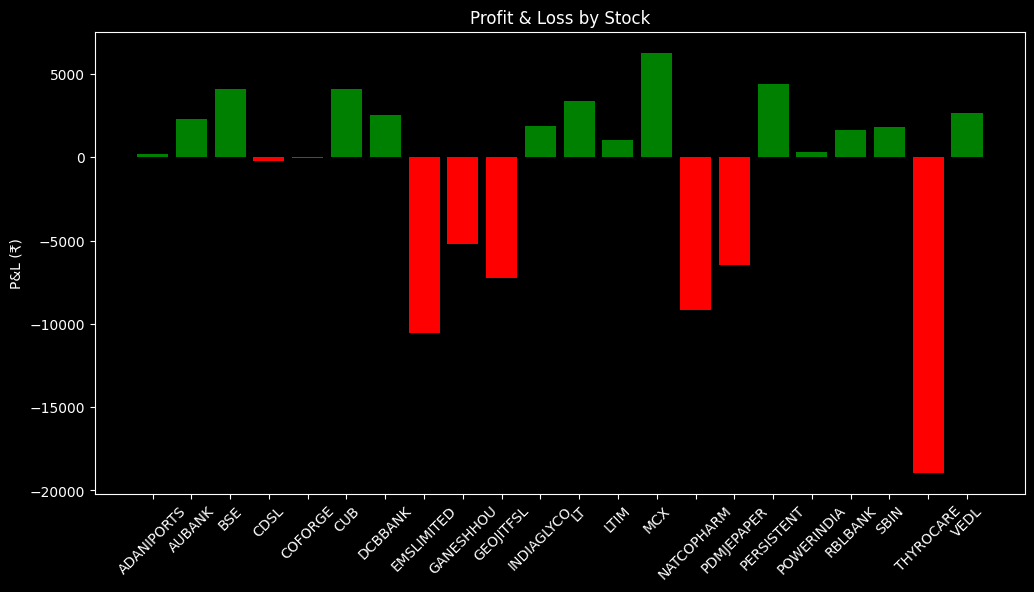

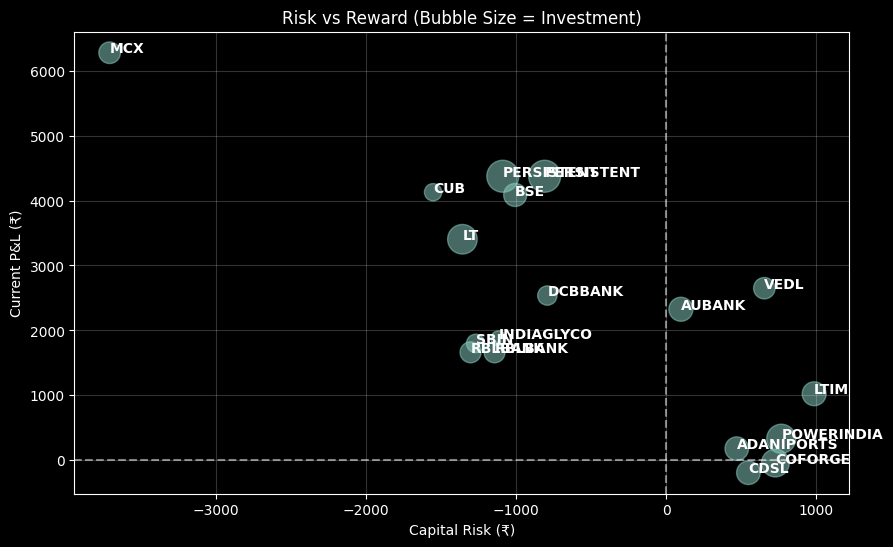

In [4]:
display_dashboard(kite)